In [3]:
# load the .tif stack
# convert to .png
# load the .png stack
# analyze the .png stack

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

with Image.open("HEK Cap URoC RyR Dec 16 2024.tif") as img:
    frames = []
    print(f"Number of frames: {img.n_frames}")
    for i in range(img.n_frames):
        img.seek(i)
        frames.append(img.copy())

frames = np.array(frames)
print(frames.shape)

# Apply Gaussian smoothing in time dimension
from scipy.ndimage import gaussian_filter1d, gaussian_filter

# Subtract background to remove drift and keep local variations
smoothed_frames = gaussian_filter1d(frames, sigma = 9, axis=0)
smoothed_frames = gaussian_filter(smoothed_frames, sigma=0.5, axes=(1, 2))

Number of frames: 1000
(1000, 864, 641)


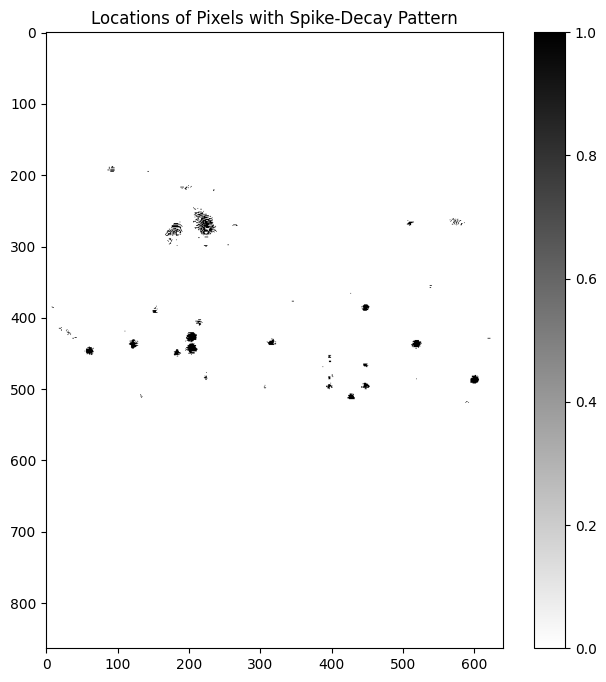

In [4]:
# Calculate temporal derivatives
temporal_diff = np.diff(smoothed_frames, axis=0)

# Find pixels with sharp rises (large positive derivatives) followed by slower decays
rise_threshold = np.percentile(temporal_diff, 95)  # Adjust percentile as needed
decay_threshold = np.percentile(-temporal_diff, 75)  # Less strict threshold for decay

# Initialize mask for pixels meeting criteria
spike_decay_pixels = np.zeros(temporal_diff.shape[1:], dtype=bool)

for y in range(temporal_diff.shape[1]):
    for x in range(temporal_diff.shape[2]):
        pixel_diff = temporal_diff[:, y, x]
        # Find sharp rises
        rise_points = np.where(pixel_diff > rise_threshold)[0]
        
        if len(rise_points) > 0:
            for rise_point in rise_points:
                # Look at the next few frames for decay
                decay_window = 5  # Adjust window size as needed
                if rise_point + decay_window < len(pixel_diff):
                    decay_region = pixel_diff[rise_point:rise_point + decay_window]
                    # Check if most points in decay region are negative
                    if np.mean(decay_region < 0) > 0.7:  # At least 70% of points should show decay
                        spike_decay_pixels[y, x] = True
                        break

# Visualize the locations of identified pixels
plt.figure(figsize=(8, 8))
plt.imshow(spike_decay_pixels, cmap='binary')
plt.title('Locations of Pixels with Spike-Decay Pattern')
plt.colorbar()
plt.show()


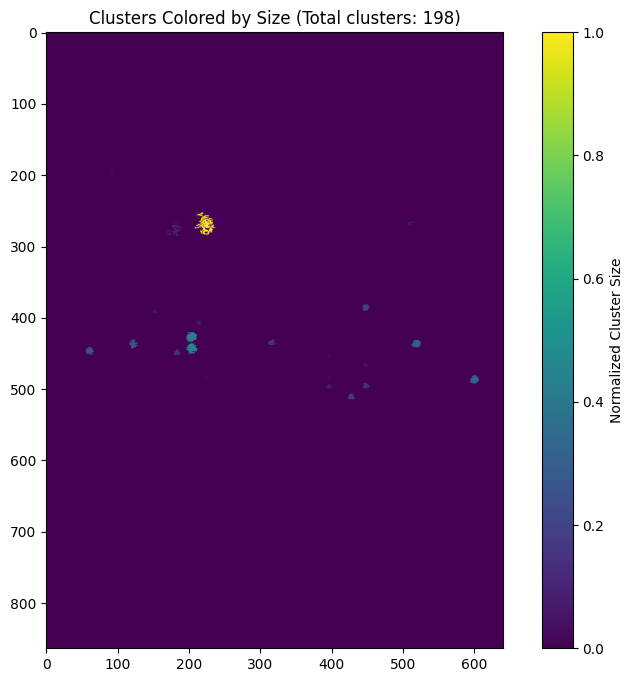

Number of clusters: 198
Average cluster size: 10.01 pixels
Median cluster size: 1.50 pixels
Min cluster size: 1 pixels
Max cluster size: 343 pixels


In [5]:
# Use scipy.ndimage to label connected components in the spike_decay_pixels mask
from scipy import ndimage

# Label connected components (clusters)
labeled_array, num_features = ndimage.label(spike_decay_pixels)

# Calculate size of each cluster
cluster_sizes = np.array([np.sum(labeled_array == i) for i in range(1, num_features + 1)])

# Create a colormap that maps cluster sizes to colors
# Normalize cluster sizes to 0-1 range for coloring
if num_features > 0:
    normalized_sizes = (cluster_sizes - cluster_sizes.min()) / (cluster_sizes.max() - cluster_sizes.min())
    
    # Create colored image where each cluster is colored by its size
    colored_clusters = np.zeros_like(labeled_array, dtype=float)
    for i in range(num_features):
        colored_clusters[labeled_array == (i + 1)] = normalized_sizes[i]
    
    # Plot the colored clusters
    plt.figure(figsize=(10, 8))
    plt.imshow(colored_clusters, cmap='viridis')
    plt.colorbar(label='Normalized Cluster Size')
    plt.title(f'Clusters Colored by Size (Total clusters: {num_features})')
    plt.show()
    
    # Print statistics about cluster sizes
    print(f"Number of clusters: {num_features}")
    print(f"Average cluster size: {np.mean(cluster_sizes):.2f} pixels")
    print(f"Median cluster size: {np.median(cluster_sizes):.2f} pixels")
    print(f"Min cluster size: {np.min(cluster_sizes)} pixels")
    print(f"Max cluster size: {np.max(cluster_sizes)} pixels")


In [6]:
# Create interactive slider for threshold
from ipywidgets import interact, IntSlider

def plot_filtered_clusters(THRESHOLD):
    # Filter clusters above threshold
    large_clusters = labeled_array.copy()
    for i in range(num_features):
        if cluster_sizes[i] <= THRESHOLD:
            large_clusters[large_clusters == (i + 1)] = 0

    # Count remaining clusters
    remaining_clusters = len(np.unique(large_clusters)) - 1  # Subtract 1 to exclude background (0)

    # Create colored image of large clusters
    if remaining_clusters > 0:
        # Get sizes of remaining clusters
        large_cluster_sizes = np.array([np.sum(large_clusters == i) for i in range(1, np.max(large_clusters) + 1) if np.sum(large_clusters == i) > 0])
        
        # Color the clusters with absolute sizes (no normalization)
        colored_large_clusters = np.zeros_like(large_clusters, dtype=float)
        current_idx = 0
        for i in range(np.max(large_clusters)):
            if np.sum(large_clusters == (i + 1)) > 0:
                colored_large_clusters[large_clusters == (i + 1)] = large_cluster_sizes[current_idx]
                current_idx += 1
        
        # Plot the filtered clusters
        plt.figure(figsize=(10, 8))
        plt.imshow(colored_large_clusters, cmap='viridis')
        plt.colorbar(label='Cluster Size (pixels)')
        plt.title(f'Large Clusters (>{THRESHOLD} pixels) Colored by Size\nRemaining clusters: {remaining_clusters}')
        plt.show()
        
        # Print statistics about large cluster sizes
        print(f"Number of large clusters: {remaining_clusters}")
        print(f"Average large cluster size: {np.mean(large_cluster_sizes):.2f} pixels")
        print(f"Median large cluster size: {np.median(large_cluster_sizes):.2f} pixels")
        print(f"Min large cluster size: {np.min(large_cluster_sizes)} pixels")
        print(f"Max large cluster size: {np.max(large_cluster_sizes)} pixels")

# Create slider with reasonable range based on cluster size statistics
max_threshold = int(np.max(cluster_sizes))
interact(plot_filtered_clusters, 
        THRESHOLD=IntSlider(min=1, 
                          max=max_threshold,
                          step=1, 
                          value=10,
                          description='Threshold:',
                          continuous_update=False))


interactive(children=(IntSlider(value=10, continuous_update=False, description='Threshold:', max=343, min=1), …

<function __main__.plot_filtered_clusters(THRESHOLD)>

Found 11 clusters with more than 50 pixels


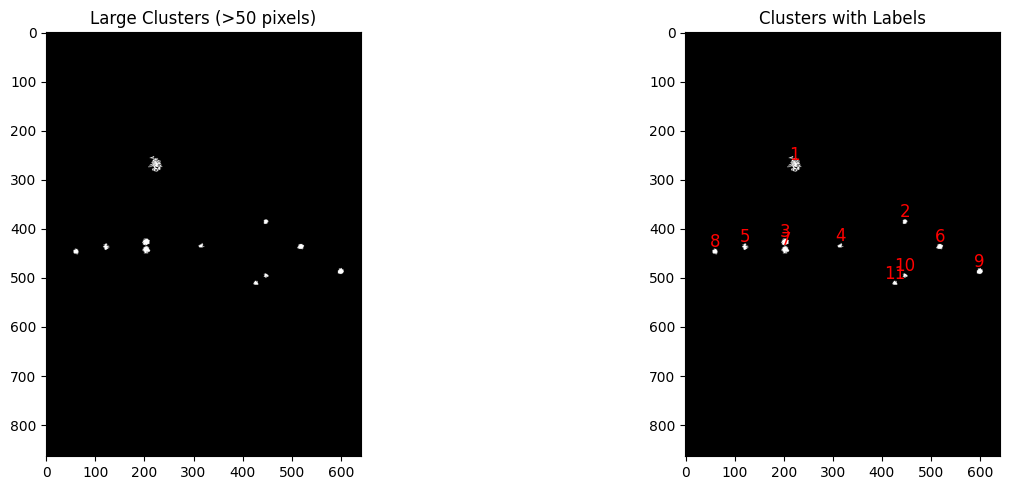

In [7]:
# Find clusters with >50 pixels and plot with labels
large_clusters = labeled_array.copy()
min_size = 50

# Filter out small clusters
for i in range(num_features):
    if cluster_sizes[i] <= min_size:
        large_clusters[large_clusters == (i + 1)] = 0

# Get remaining cluster labels
remaining_cluster_labels = np.unique(large_clusters)[1:]  # Skip 0 which is background
num_remaining = len(remaining_cluster_labels)

print(f"Found {num_remaining} clusters with more than {min_size} pixels")

# Create figure
plt.figure(figsize=(15, 5))

# Plot original clusters
plt.subplot(121)
plt.imshow(large_clusters > 0, cmap='gray')
plt.title(f'Large Clusters (>{min_size} pixels)')

# Plot labeled clusters
plt.subplot(122)
labeled_img = large_clusters.copy()
for idx, label in enumerate(remaining_cluster_labels):
    # Get center of mass for this cluster
    cluster_coords = np.where(large_clusters == label)
    center_y = np.mean(cluster_coords[0])
    center_x = np.mean(cluster_coords[1])
    
    # Add text label, shifted up by 20 pixels
    plt.text(center_x, center_y - 20, str(idx+1), 
             color='red', fontsize=12, ha='center', va='center')

plt.imshow(labeled_img > 0, cmap='gray')
plt.title('Clusters with Labels')

plt.tight_layout()
plt.show()


Found 11 clusters with more than 50 pixels


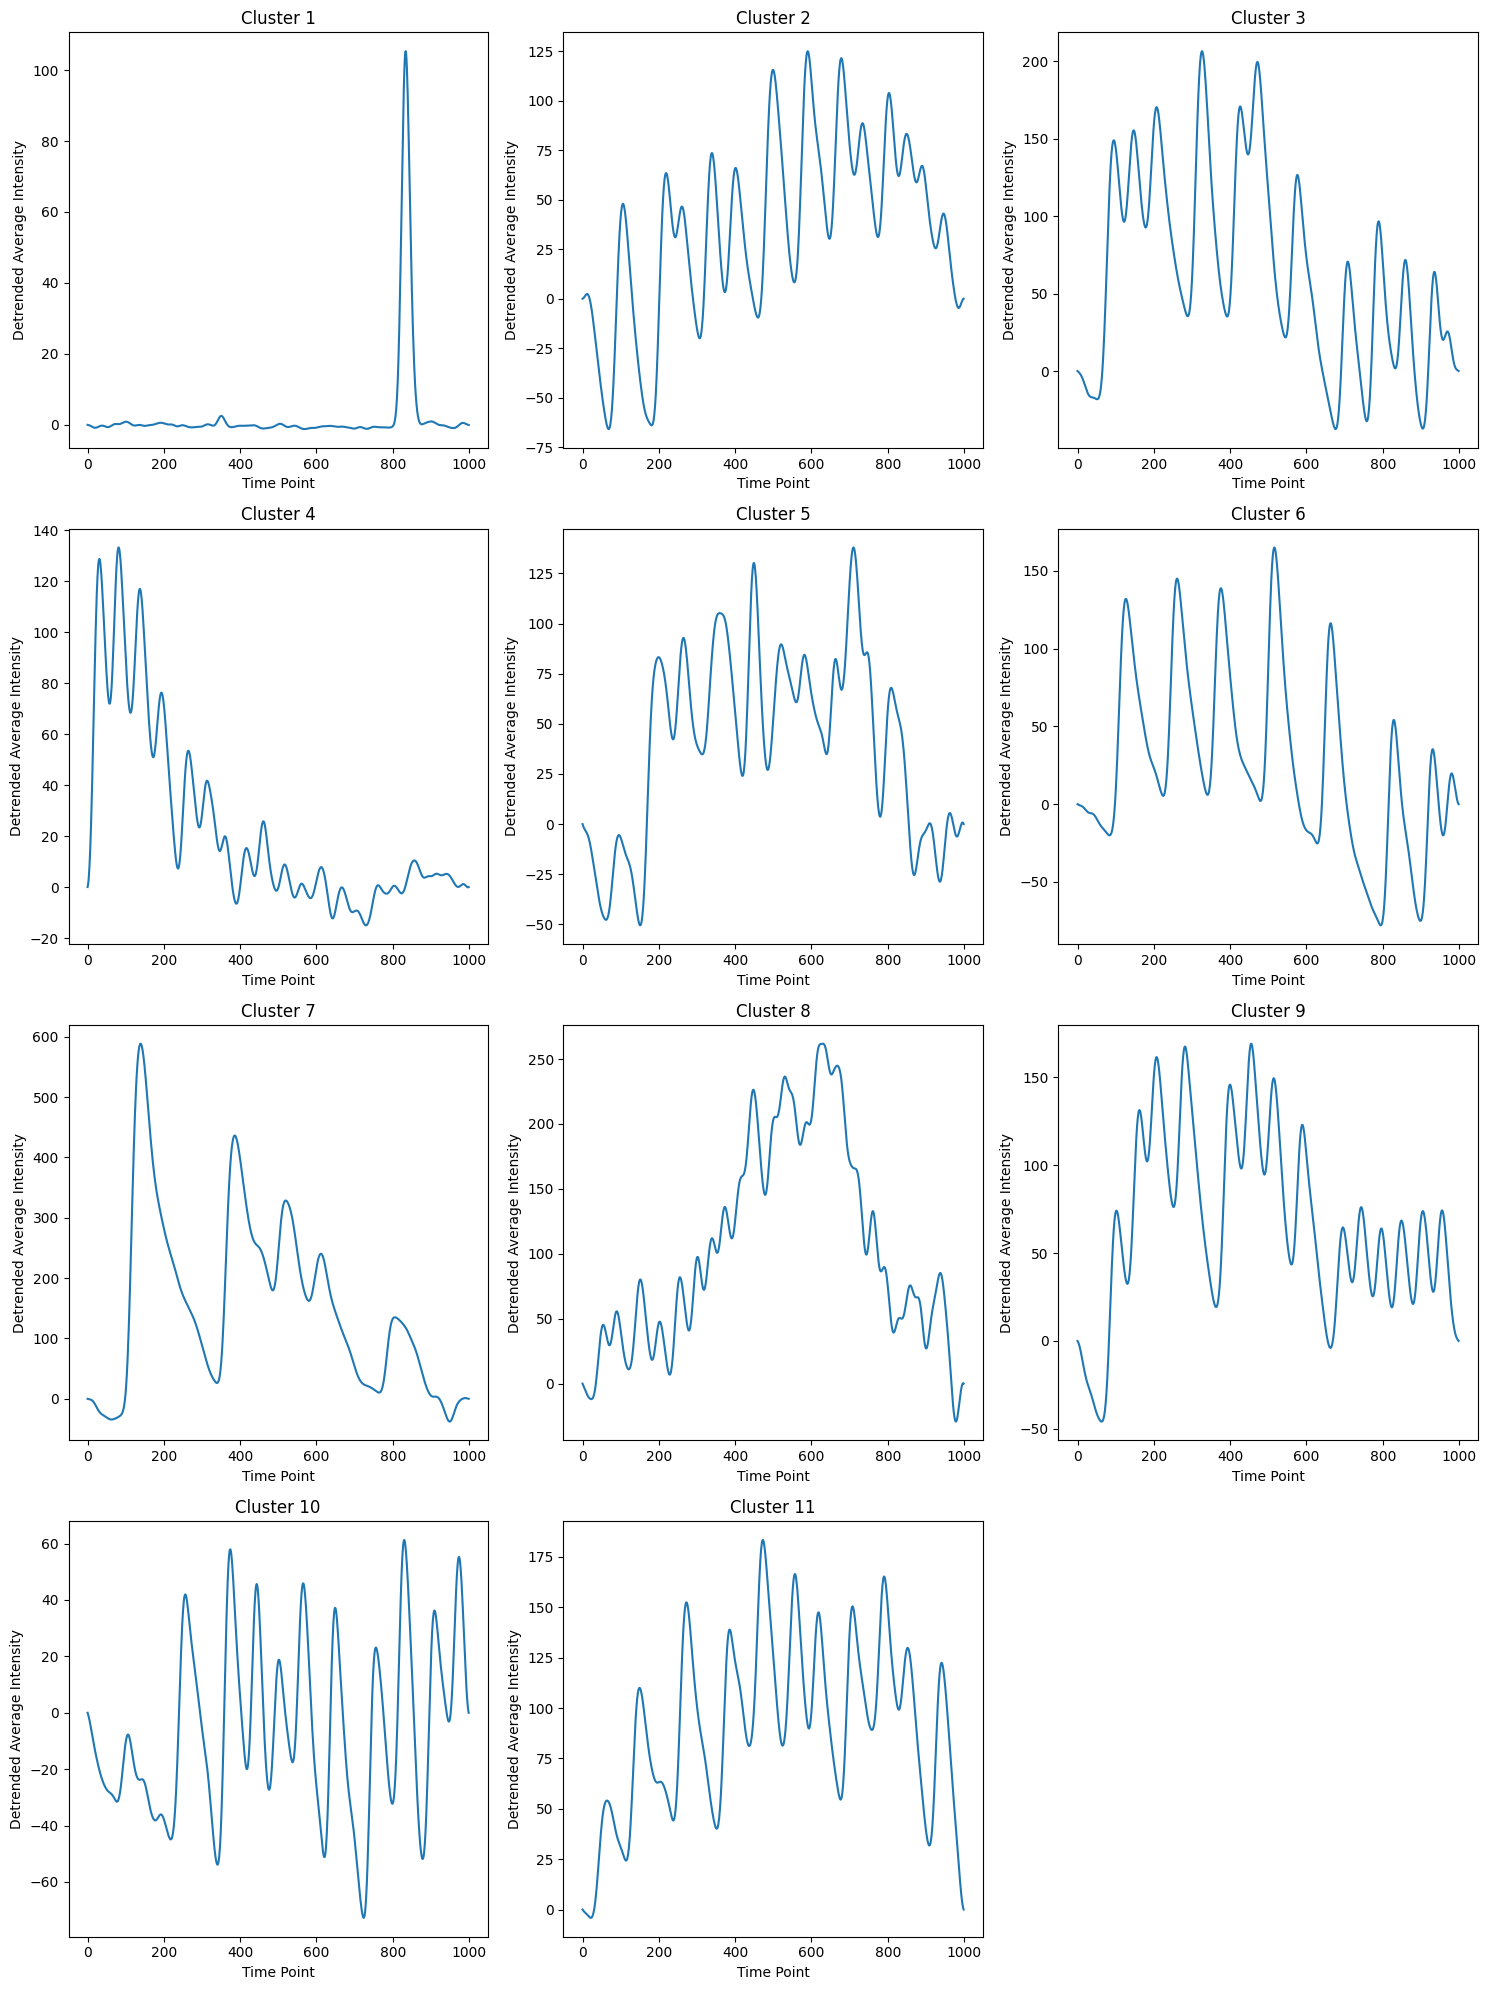

In [8]:
# Find clusters with >50 pixels and calculate average intensity over time
large_clusters = labeled_array.copy()
min_size = 50

# Filter out small clusters
for i in range(num_features):
    if cluster_sizes[i] <= min_size:
        large_clusters[large_clusters == (i + 1)] = 0

# Get remaining cluster labels
remaining_cluster_labels = np.unique(large_clusters)[1:]  # Skip 0 which is background
num_remaining = len(remaining_cluster_labels)

print(f"Found {num_remaining} clusters with more than {min_size} pixels")

# Calculate average intensity vs time for each large cluster
cluster_intensities = []
for label in remaining_cluster_labels:
    # Create mask for this cluster
    cluster_mask = (large_clusters == label)
    
    # Get all pixels in this cluster across time
    cluster_pixels = smoothed_frames[:, cluster_mask]  # This will be (time_points, pixels_in_cluster)
    
    # Calculate mean intensity at each timepoint
    mean_intensity = np.mean(cluster_pixels, axis=1)
    cluster_intensities.append(mean_intensity)

# Convert to numpy array for easier manipulation
cluster_intensities = np.array(cluster_intensities)  # Shape: (num_clusters, time_points)

# Calculate and subtract linear trend for each cluster
detrended_intensities = []
time_points = np.arange(cluster_intensities.shape[1])
for intensity in cluster_intensities:
    # Get first and last points
    start_point = intensity[0]
    end_point = intensity[-1]
    
    # Calculate linear trend
    slope = (end_point - start_point) / (len(time_points) - 1)
    trend = start_point + slope * time_points
    
    # Subtract trend from intensity
    detrended = intensity - trend
    detrended_intensities.append(detrended)

detrended_intensities = np.array(detrended_intensities)

# Plot each cluster's detrended intensity in a separate subplot
num_cols = 3
num_rows = (num_remaining + 2) // 3  # Round up division
plt.figure(figsize=(15, 5*num_rows))

for i in range(len(detrended_intensities)):
    plt.subplot(num_rows, num_cols, i+1)
    plt.plot(time_points, detrended_intensities[i])
    plt.xlabel('Time Point')
    plt.ylabel('Detrended Average Intensity')
    plt.title(f'Cluster {i+1}')

plt.tight_layout()
plt.show()


In [9]:
# Find peaks in detrended data for each cluster
from scipy.signal import find_peaks
import pandas as pd

spike_stats = []
for i, intensity in enumerate(detrended_intensities):
    # Find peaks using scipy.signal.find_peaks
    # Adjust height and distance parameters as needed based on your data
    peaks, _ = find_peaks(intensity, height=0.5*np.std(intensity), 
                                distance=5)  # Minimum 5 timepoints between peaks
    
    if len(peaks) > 1:
        # Calculate time between spikes
        inter_spike_intervals = np.diff(peaks)
        avg_interval = np.mean(inter_spike_intervals)
        std_interval = np.std(inter_spike_intervals)
    else:
        avg_interval = np.nan
        std_interval = np.nan
    
    spike_stats.append({
        'cluster': i+1,
        'num_spikes': len(peaks),
        'avg_interval': avg_interval,
        'std_interval': std_interval
    })

# Convert to DataFrame for easy viewing
spike_df = pd.DataFrame(spike_stats)
print("\nSpike Statistics for Each Cluster:")
print(spike_df)



Spike Statistics for Each Cluster:
    cluster  num_spikes  avg_interval  std_interval
0         1           1           NaN           NaN
1         2          13     70.000000     22.719302
2         3          11     84.100000     27.354890
3         4           8     61.428571     17.767202
4         5          10     67.777778     17.849854
5         6           7    134.000000     20.872630
6         7           5    166.500000     58.538449
7         8          20     46.526316     17.886685
8         9          14     65.692308     21.850487
9        10          10     79.666667     19.241160
10       11          12     79.727273     16.310013
